In [47]:
import chess
from stockfish import Stockfish
from ollama import chat
from ollama import ChatResponse
import json
import pandas as pd

In [48]:
# STOCKFISH_PATH = r"C:\Users\nafis\Downloads\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe"

STOCKFISH_ELO = 3500

NUM_GAMES = 1

In [49]:
stockfish = Stockfish()


In [50]:
stockfish_wins = 0
qwen_wins = 0
draws = 0

In [51]:
def valid_move_to_string(board):
    legal_moves = [
        board.san(move)
        for move in board.legal_moves
]
    
    moves = str(legal_moves[0])  # Start with the first move

    for move in legal_moves[1:]:  # Skip the first move and iterate over the rest
        moves = moves + " " + move
    return moves

In [52]:
def get_move_history(board: chess.Board) -> str:
    """Return a formatted move history string like '1. e4 e5 2. Nf3 d5'."""
    temp_board = chess.Board()  # Start from the initial position.
    move_history = []
    
    # Iterate over the moves in the board's move stack.
    for i, move in enumerate(board.move_stack):
        # Get the SAN for the move in the current temporary board.
        move_san = temp_board.san(move)
        # Push the move so that the board state is updated.
        temp_board.push(move)
        
        # For white moves (even index), start a new entry with move number.
        if i % 2 == 0:
            move_history.append(f"{i//2 + 1}. {move_san}")
        # For black moves, append to the last white move entry.
        else:
            move_history[-1] += f" {move_san}"
    
    # Join all entries with a space.
    return " ".join(move_history)

In [53]:
def get_qwen_move(board:chess.Board, fen:str, temp=0.0):
    valid_moves = valid_move_to_string(board)

    move_history = get_move_history(board)
    
    response: ChatResponse = chat(model='qwen:32b', messages=[
        {
            'role': 'user',
            'content': f"""You are playing chess as White and it is your turn. This is the current state of the game. Use this to work out where the pieces are on the board:

FEN: {fen}

The possible set of legal moves are: 

Legal Moves: {valid_moves}

You have to choose one from the provided list. Do not choose a move that is not in the list.

The move history is: {move_history}.

Output the best move in SAN format to follow this position. Use the following single blob of JSON. Do not include any other information.
{{
    "san": "The move in SAN format",
    "reason": "Why this is a good move"
}}"""}], options={"temperature": temp})
    
    try:
        parsed_json = json.loads(response.message.content)
        qwen_move = parsed_json["san"]
    except Exception as e:
        print(f"Wrong format given by Qwen. \nQwen Output: {response.message.content}")

    

    return qwen_move

In [54]:
def get_random_move(board:chess.Board, fen:str, seed: int = 101):
    legal_moves = [
        board.san(move)
        for move in board.legal_moves
    ]

    random.seed(seed)

    # print(random.choice(legal_moves))
    return random.choice(legal_moves)

    # print(legal_moves[0])

In [55]:
for game_number in range(1, NUM_GAMES + 1):
    print(f"Starting game {game_number}...")
    board = chess.Board()

    while not board.is_game_over():
        if board.turn == chess.WHITE:
            qwen_move = get_qwen_move(board, board.fen(), 2)

            # if qwen_move not in board.legal_moves:
            #     print(f"Invalid move by Qwen. Move: {qwen_move}")
            #     qwen_move = get_random_move(board, board.fen(), 42)
            #     board.push_san(qwen_move)

            try:
                board.push_san(qwen_move)
            except Exception as e:
                print(f"Invalid move by Qwen. Move: {qwen_move}")
                # qwen_move = get_random_move(board, board.fen(), 42)
                # board.push_san(qwen_move)
                continue
    
        print(f"Qwen move: {qwen_move}")
        board

        if board.turn == chess.BLACK:
            stockfish.set_fen_position(board.fen())

            stockfish_move = stockfish.get_best_move()

            print(f"Stockfish move: {stockfish_move}")

            board.push_uci(stockfish_move)

        board


            


        # # Determine which engine to use based on turn
        # current_engine = high_elo_engine if board.turn == chess.WHITE else low_elo_engine

        # # Set the position on the board for the engine
        # current_engine.set_fen_position(board.fen())

        # # Get the best move from the engine
        # best_move = current_engine.get_best_move()
        # if best_move is None:
        #     print("Engine failed to provide a move.")
        #     break

        # # Apply the move to the board
        # move = chess.Move.from_uci(best_move)
        # board.push(move)

    # Record the result of the game
    result = board.result()
    if result == "1-0":
        qwen_wins += 1
    elif result == "0-1":
        stockfish_wins += 1
    else:
        draws += 1

    print(f"Game {game_number} result: {result}\n")

Starting game 1...
Qwen move: e4
Stockfish move: c7c5
Qwen move: Nf3
Stockfish move: b8c6
Qwen move: Nc3
Stockfish move: e7e5
Qwen move: Nh4
Stockfish move: d8h4
Invalid move by Qwen. Move: Nbd2
Invalid move by Qwen. Move: Nf3
Invalid move by Qwen. Move: Nbd2


KeyboardInterrupt: 

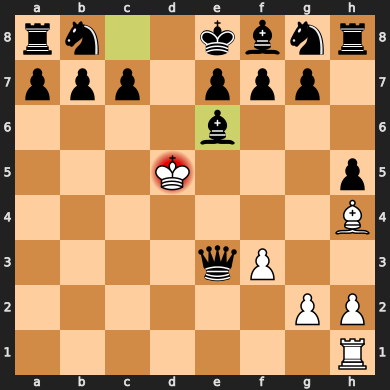

In [ ]:
board

In [ ]:
print(f"Final Results after {NUM_GAMES} games:")
print(f"High ELO Wins: {high_elo_wins}")
print(f"Low ELO Wins: {low_elo_wins}")
print(f"Draws: {draws}")


Final Results after 1 games:


NameError: name 'high_elo_wins' is not defined

In [ ]:
with open("elo_match_results.txt", "w") as result_file:
    result_file.write(f"Final Results after {NUM_GAMES} games:\n")
    result_file.write(f"High ELO Wins: {high_elo_wins}\n")
    result_file.write(f"Low ELO Wins: {low_elo_wins}\n")
    result_file.write(f"Draws: {draws}\n")
